In [50]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [51]:
import numpy as np
import matplotlib.pyplot as plt

We're going to sample a multivariate Gaussian density given by

$$
p(\vec{x}) \propto \exp{\left[ -\frac{1}{2} (\vec{x}-\vec{\mu})^{\intercal} \,\Sigma^{-1}(\vec{x}-\vec{\mu}) \right]} 
$$
where
- $\vec{\mu}$ is an N-dimensional vector postion of the mean of the density
- $\Sigma$ is the square N-by-N covariance matrix

The is a function which return the density $p(\vec{x})$ for specific values of $\vec{x}$,
$\vec{\mu}$ and $\Sigma^{-1}$. Actually, it returns the log of $p$ which is what `emcee` expects.

The first argument is the position of a single "walker" (a N-dimensional numpy array). The
following arguments will be constant with the values coming from the args parameter of
an `EnsembleSample` which we'll see later.

In [52]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

Now we can start to set up the hyperparameters

In [53]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)
print(f"means = {means}")

# this is setting up the N-by-N (here 5-by-5) covariance matrix (\Sigma). Start with random values.
cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
print(f"initial cov =\n{cov}")

# Get the upper right triangle of the matrix (diagonal and all right & above) with the rest set zero
# then "mirror" this (w/o the diagonal) and set to lower left triangle to give a symmetric matrix.
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
print(f"symmetric cov =\n{cov}")

# Now get cov.cov
cov = np.dot(cov, cov)
print(f"Sigma = np.dot(cov, cov) =\n{cov}")

means = [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
initial cov =
[[ 0.34400548  0.44191639 -0.36617615 -0.10111501 -0.20807258]
 [ 0.47941551 -0.46990985 -0.33244264  0.28766089  0.31817503]
 [ 0.31659549  0.19575776 -0.02475643  0.06805498  0.20877086]
 [-0.11185289  0.36050614  0.20785535  0.13363816  0.04393002]
 [-0.28517596  0.30032622 -0.01423444 -0.09241457  0.45354959]]
symmetric cov =
[[ 0.34400548  0.44191639 -0.36617615 -0.10111501 -0.20807258]
 [ 0.44191639 -0.46990985 -0.33244264  0.28766089  0.31817503]
 [-0.36617615 -0.33244264 -0.02475643  0.06805498  0.20877086]
 [-0.10111501  0.28766089  0.06805498  0.13363816  0.04393002]
 [-0.20807258  0.31817503  0.20877086  0.04393002  0.45354959]]
Sigma = np.dot(cov, cov) =
[[ 0.50123328 -0.02919697 -0.31413411  0.04476438 -0.10623147]
 [-0.02919697  0.71060761  0.08863136 -0.15006354 -0.1539235 ]
 [-0.31413411  0.08863136  0.29343271 -0.04202359  0.06292544]
 [ 0.04476438 -0.15006354 -0.04202359  0.11739352  0.1525

How about we use 32 walkers? Before we go on, we need to guess a starting point for each of the 32 walkers. This position will be a 5-dimensional vector so the initial guess should be a 32-by-5 array. It’s not a very good guess but we’ll just guess a random number between 0 and 1 for each component:

In [54]:
# randomly initialize the walkers
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)
#p0

The main interface provided by `emcee` is the `EnsembleSampler` object.

In [55]:
import emcee

# args are passed as *args to log_prob_fn (there's also a kwargs equivalent)
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=log_prob, args=[means, cov])


We set it up to call the `log_prob()` function with the `args`, effectively;

In [56]:
log_prob(p0[0], means, cov)

-2.596094589085444

It's a good idea to run some burn-in steps to let the walkers explore the parameter space
and get settled into the maximum of the density.

In [57]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

This will save the positions of the walkers after the burn-in into `state`. The call to
`sampler.reset()` clears all of the important bookkeeping params (including the positions
of the walkers) in the sampler.

Now we can do a "production" run of 10\,000 steps.

In [58]:
niters = 10000
sampler.run_mcmc(state, niters, progress=True)

100%|██████████| 10000/10000 [00:03<00:00, 2742.11it/s]


State([[-0.43424014  1.78803091  0.75224634  0.65915817  0.4734423 ]
 [-0.71238895  0.73426195  1.61712787  0.01255936 -0.88053699]
 [-0.12594128  1.35599541  1.45238318  0.67980103  0.04012247]
 [ 0.61314205  0.05575063  0.08529774  0.33867444 -0.50362248]
 [-0.43664707  0.80436207  1.13204378  0.09380783 -0.86993763]
 [ 0.46853993  0.33075848  1.3573585   0.6343816  -0.06090445]
 [ 1.33160321  0.85641285  0.24891645  0.60504798  0.31227906]
 [-0.01892609 -0.69794138  0.75504743  0.57176373 -0.56125437]
 [ 0.10126089  0.83103772  0.41637254  1.19650469  0.94380252]
 [ 0.77011537  1.04838809  0.34784618  0.23919228 -0.68069185]
 [ 0.34249082  1.74170469  0.2715152   0.44037013  0.33070086]
 [ 0.63990461  0.20794172  0.55347742  0.50262532  0.59795591]
 [-0.61191978  0.87287941  0.72937147  0.46822771 -0.10662417]
 [ 1.3868385   1.24258573  0.42448945  0.96352562  0.7483911 ]
 [ 0.23483736  0.92491094  0.7886009   0.5403674  -0.20953847]
 [ 0.79224679  2.26723672  0.59926754  0.05649208

Samples can be accessed with the `get_chain()` method. In this case it will return an array
of shape (#steps, #walkers, #ndim) [so (10000, 32, 5)] giving the parameters for each walker
at each step of the chain.

You can make histograms of the samples to get an estimate of the density we're sampling;

sampler.get_chain().shape=(10000, 32, 5)
sampler.get_chain(flat=True).shape=(320000, 5)


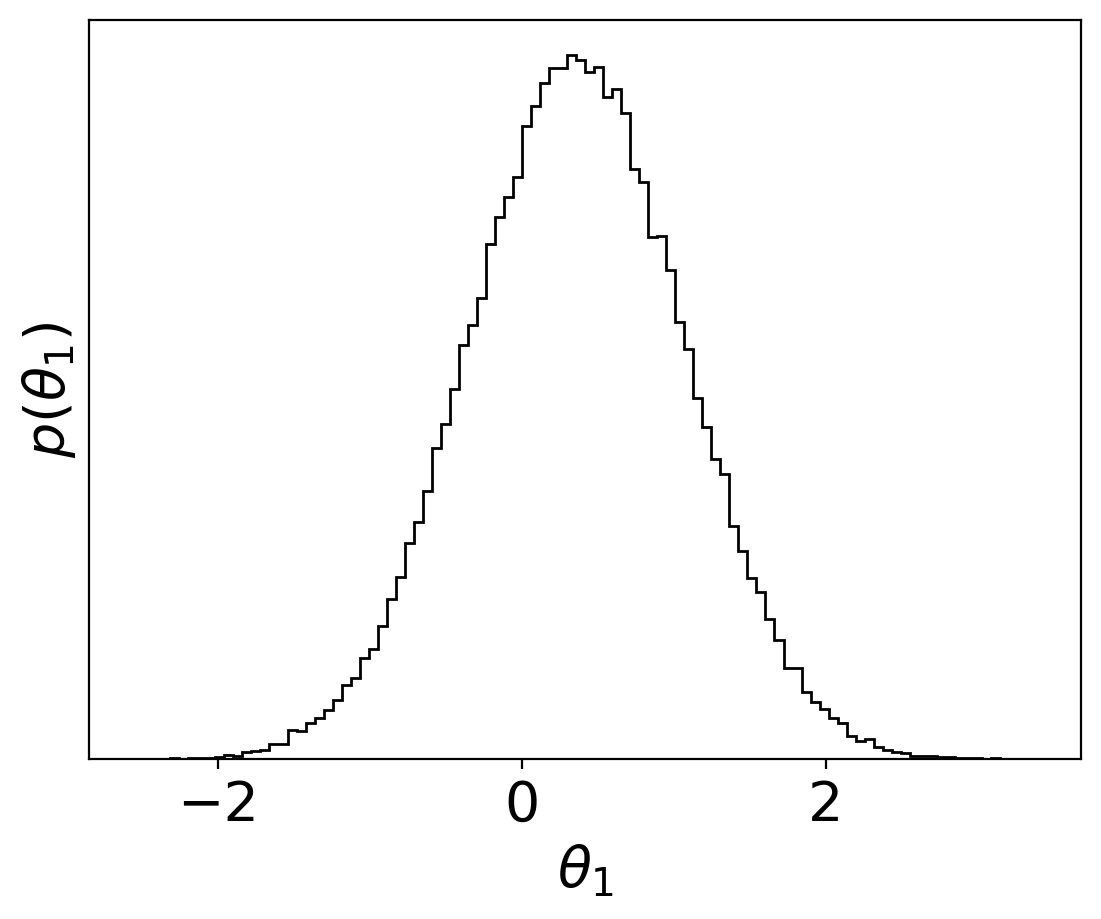

In [59]:
# By default, samples with have shape (niters, nwalkers, ndim); in this case (10000, 32, 5)
# with flat=True this is flattened to shape (niters*nwalkers, ndim)
print(f"sampler.get_chain().shape={sampler.get_chain().shape}")
samples = sampler.get_chain(flat=True)
print(f"sampler.get_chain(flat=True).shape={samples.shape}")

plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Another good test of whether or not the sampling went well is to check the acceptance fraction
of the ensemble using the `acceptance_fraction` attribute and the integrated aurocorrelation
time.

In [60]:
print(f"Mean acceptance fraction:  {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time: {np.mean(sampler.get_autocorr_time()):.3f}")

Mean acceptance fraction:  0.552
Mean autocorrelation time: 57.112
